# Lid-Driven Cavity Problem: Vorticity-Streamfunction Approach

The **lid-driven cavity problem** is a classic benchmark in computational fluid dynamics (CFD). It involves solving the incompressible Navier-Stokes equations in a square domain where the top lid moves with a constant velocity, while the other three walls are stationary.

This setup produces a primary vortex in the cavity's center and secondary vortices near the corners, depending on the Reynolds number (\(Re\)).

---

## Objectives of the Notebook

1. Formulate the governing equations for incompressible fluid flow using the vorticity-streamfunction approach.
2. Implement the numerical solution using finite difference methods and JAX for GPU acceleration.
3. Visualize the streamfunction, vorticity, and velocity fields.

---

## Governing Equations
We use the **vorticity-streamfunction formulation** of the Navier-Stokes equations, which simplifies the incompressibility condition.

### Vorticity-Streamfunction Formulation

1. **Vorticity Transport Equation**:
   $
   \frac{\partial \omega}{\partial t} + \vec{u} \cdot \nabla \omega = \nu \nabla^2 \omega,
   $
   where:
   - $ \omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} $: Vorticity,
   - $ \vec{u} = (u, v) $: Velocity field,
   - $ \nu = \frac{1}{Re} $: Kinematic viscosity.

2. **Streamfunction-Vorticity Relation**:
   $
   \nabla^2 \psi = -\omega,
   $
   where $ \psi $ is the streamfunction, and the velocity components are derived as:
   $
   u = \frac{\partial \psi}{\partial y}, \quad v = -\frac{\partial \psi}{\partial x}.
   $

3. **Boundary Conditions**:
   - **Top Wall (lid)**: $ u = U $, $ v = 0 $,
   - **Other Walls**: $ u = 0 $, $ v = 0 $,
   - Vorticity ($ \omega $) is determined using finite difference approximations.

---

## Numerical Approach
We discretize the equations using the finite difference method:
1. **Vorticity Transport Equation**:
   - Explicit Euler time-stepping.
   - Central difference for spatial derivatives.
2. **Streamfunction Equation**:
   - Iterative solution using the Jacobi method.

---

### Domain and Grid
The computational domain is a square cavity of length $ L $. The grid has $ N \times N $ points, with a spacing of $\Delta x = \Delta y $.

---

## Key Steps
1. Initialize the grid and apply boundary conditions.
2. Solve the Poisson equation for the streamfunction at each time step.
3. Update vorticity using the vorticity transport equation.
4. Visualize the results.

**Problem Setup**

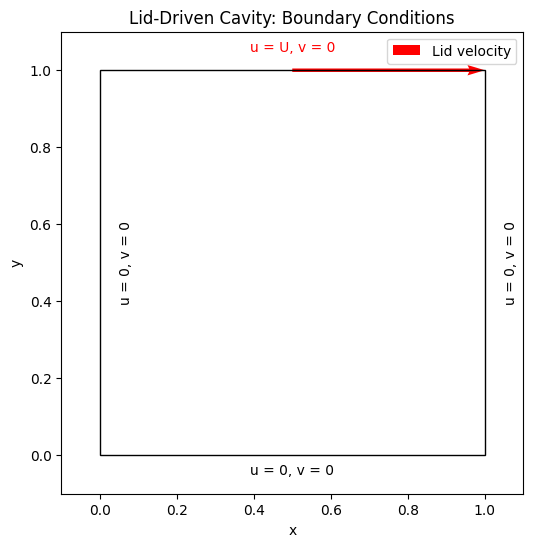

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the cavity
plt.figure(figsize=(6, 6))
plt.quiver([0.5], [1.0], [0.5], [0.0], angles='xy', scale_units='xy', scale=1, color='r', label="Lid velocity")
plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, fill=None, edgecolor="black"))
plt.text(0.5, 1.05, "u = U, v = 0", ha='center', color='red')
plt.text(0.05, 0.5, "u = 0, v = 0", va='center', rotation=90)
plt.text(0.5, -0.05, "u = 0, v = 0", ha='center')
plt.text(1.05, 0.5, "u = 0, v = 0", va='center', rotation=90)
plt.axis("scaled")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title("Lid-Driven Cavity: Boundary Conditions")
plt.legend()
plt.show()

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Poisson solver using Jacobi iteration
@jax.jit
def solve_poisson_jacobi(omega, psi, h, max_iter=500, tol=1e-6):
    h2 = h * h
    for _ in range(max_iter):
        psi_new = (psi[1:-1, 2:] + psi[1:-1, :-2] + psi[2:, 1:-1] + psi[:-2, 1:-1] + omega[1:-1, 1:-1] * h2) / 4.0
        psi = psi.at[1:-1, 1:-1].set(psi_new)

        # Compute the residual for convergence check (optional)
        residual = jnp.linalg.norm(psi_new - psi[1:-1, 1:-1])
        # if residual < tol:
        #     break

    return psi

# Lid-driven cavity solver
def cavity(Re, N, T):
    # Parameters
    Uwall = 1.0
    L = 1.0
    nu = Uwall * L / Re
    s = jnp.linspace(0.0, 1.0, N + 1)
    h = s[1] - s[0]
    h2 = h * h
    Y, X = jnp.meshgrid(s, s)

    # Initialize variables
    O = jnp.zeros((N + 1, N + 1))  # Vorticity
    P = jnp.zeros((N + 1, N + 1))  # Streamfunction
    Q = jnp.zeros((N + 1, N + 1))  # Temporary array for updates

    # Time stepping
    dt = min(0.25 * h2 / nu, 4.0 * nu / Uwall**2)
    Nt = int(jnp.ceil(T / dt))

    # Time loop
    for n in range(Nt):
        # Poisson solve for streamfunction
        P = solve_poisson_jacobi(O, P, h)


        # Vorticity boundary conditions
        O = O.at[1:N, 0].set(-2.0 * P[1:N, 1] / h2)  # Bottom
        O = O.at[1:N, N].set(-2.0 * P[1:N, N - 1] / h2 - 2.0 / h * Uwall)  # Top
        O = O.at[0, 1:N].set(-2.0 * P[1, 1:N] / h2)  # Left
        O = O.at[N, 1:N].set(-2.0 * P[N - 1, 1:N] / h2)  # Right

        # Vorticity update (interior nodes)
        Px = (P[1:-1, 2:] - P[1:-1, :-2]) / (2 * h)  # dP/dx
        Py = (P[2:, 1:-1] - P[:-2, 1:-1]) / (2 * h)  # dP/dy
        Ox = (O[1:-1, 2:] - O[1:-1, :-2]) / (2 * h)  # dO/dx
        Oy = (O[2:, 1:-1] - O[:-2, 1:-1]) / (2 * h)  # dO/dy

        convection = -0.25 * (Px * Oy - Py * Ox)
        diffusion = nu * (O[1:-1, 2:] + O[1:-1, :-2] + O[2:, 1:-1] + O[:-2, 1:-1] - 4.0 * O[1:-1, 1:-1]) / h2

        Q = convection + diffusion
        # Update time step
        U = jnp.abs(P[:, 1:N + 1] - P[:, 0:N]) / h
        V = jnp.abs(P[1:N + 1, :] - P[0:N, :]) / h
        vmax = max(jnp.max(U) + jnp.max(V), Uwall)
        dt = min(0.25 * h2 / nu, 4.0 * nu / vmax**2)
        #print(jnp.linalg.norm(Q))

        # Forward Euler update
        O = O.at[1:-1, 1:-1].add(dt * Q)

    return X, Y, O, P

# Run the simulation
Re = 100
N = 32
T = 10.0
X, Y, O, P = cavity(Re, N, T)

## Results
After solving the equations iteratively, we can visualize:
1. **Streamfunction $ \psi $**: Shows the streamlines of the flow.
2. **Vorticity $ \omega $**: Highlights regions of rotational flow.
3. **Velocity Field**: Displays the velocity vectors or contours.

---

### Streamfunction Plot
The streamfunction provides an intuitive understanding of the flow structure. The primary vortex is seen in the center, with possible secondary vortices in the corners at higher \( Re \).

### Vorticity Plot
The vorticity plot highlights areas of high rotational motion, particularly near the boundaries.

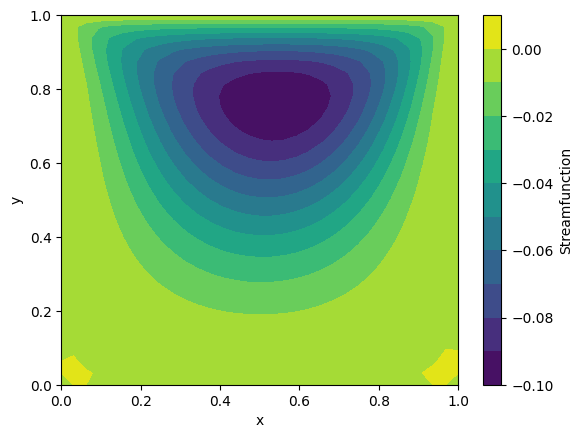

In [3]:
plt.contourf(X, Y, P, levels=10, cmap="viridis")
plt.colorbar(label="Streamfunction")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

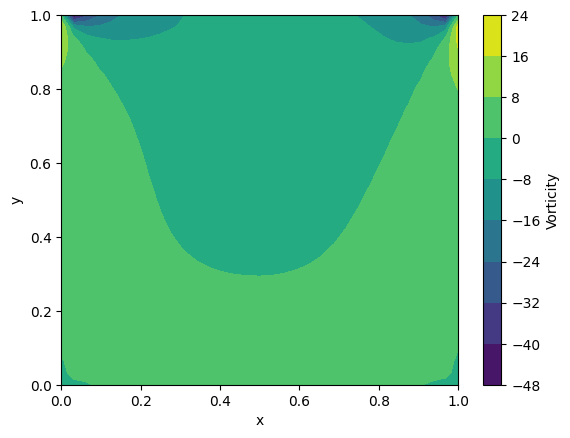

In [4]:
plt.contourf(X, Y, O, levels=10, cmap="viridis")
plt.colorbar(label="Vorticity")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

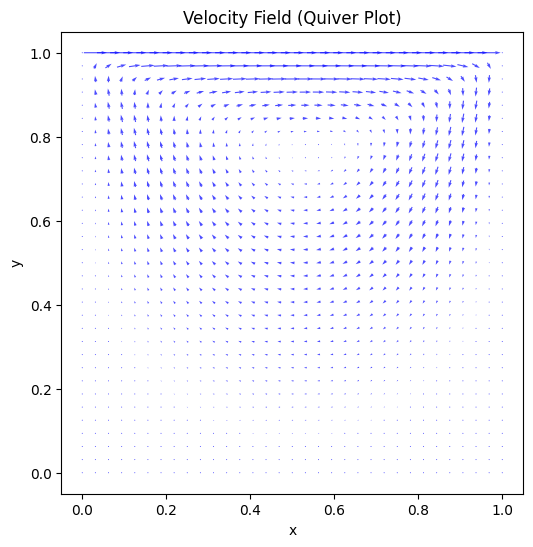

In [5]:
@jax.jit
def compute_velocity(psi,U):
    u = (psi[:, 2:] - psi[:, :-2]) / (2 * dx)  # u = dpsi/dy
    v = -(psi[2:, :] - psi[:-2, :]) / (2 * dx)  # v = -dpsi/dx
    # Pad velocity components
    u = jnp.pad(u, ((0, 0), (1, 1)), mode="constant")  # Pad in x-direction
    v = jnp.pad(v, ((1, 1), (0, 0)), mode="constant")  # Pad in y-direction

    # Apply boundary conditions for u and v
    # Top wall (lid): u = Uwall, v = 0
    u = u.at[:, -1].set(U)  # Set u to Uwall on the top boundary
    v = v.at[-1, :].set(0)     # Set v to 0 on the top boundary

    # Other walls (no-slip): u = 0, v = 0
    u = u.at[0, :].set(0)      # Bottom boundary
    u = u.at[:, 0].set(0)      # Left boundary
    u = u.at[-1, :].set(0)     # Right boundary
    v = v.at[0, :].set(0)      # Bottom boundary
    v = v.at[:, 0].set(0)      # Left boundary
    v = v.at[:, -1].set(0)     # Right boundary
    return u, v

L=1.0
dx = L/N
Uwall = 1.0
u, v = compute_velocity(P, Uwall)

# Create a quiver plot
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, u, v, scale=20, color="blue", pivot="middle", alpha=0.7)
plt.title("Velocity Field (Quiver Plot)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("scaled")
plt.show()